In [3]:
# need to run this twice due to bug in imported package

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import numpy as np
import seaborn as sns
import sys
from scipy import stats
import math

sys.path.append("../")
from protocols import Helpers
from protocols.BuildCatalogue import BuildCatalogue

from protocols.Predict import predict, predict_cv, piezo_predict, piezo_predict_cv

import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

## Data imports

In [4]:

mutations = pd.read_csv('./data/cryptic2_rev2/bdq_mutations.csv', index_col=0)
genomes = pd.read_pickle("./data/cryptic2_rev2/GENOMES.pkl.gz").reset_index()

phenotypes = pd.read_pickle("./data/cryptic2_rev2/DST_MEASUREMENTS.pkl.gz").reset_index()

#the new NICD data phenotype quality has been characterseid as 'medium', and will therefore get filtered out. We just want the UKMYC phenotype
# filtered for High quality - therefore record NICD ids to ensure they aren't removed
sha_phenotype_ids = pd.read_pickle(
   "./data/shaheed/DST_MEASUREMENTS.pkl.gz"
).reset_index().UNIQUEID.unique()

growth = pd.read_pickle("./data/cryptic2_rev2/UKMYC_GROWTH.pkl.gz").reset_index()
growth = growth[growth.DRUG=='BDQ']

## Data prep for catalogue building

In [5]:
#filter for high quality phenotypes, unless its of the new nicd samples
filtered_ids = []
for i in phenotypes.index:
    if phenotypes['UNIQUEID'][i] in sha_phenotype_ids:
        filtered_ids.append(phenotypes['UNIQUEID'][i])
    else:
        if phenotypes['QUALITY'][i] == 'HIGH':
            filtered_ids.append(phenotypes['UNIQUEID'][i])

phenotypes = phenotypes[phenotypes.UNIQUEID.isin(filtered_ids)]
phenotypes = phenotypes[phenotypes.DRUG=='BDQ']

# phenotypes = pd.concat([phenotypes, sha_phenotypes], ignore_index=True)
phenotypes = phenotypes[~phenotypes.METHOD_MIC.isna()]
phenotypes = phenotypes[~phenotypes.PHENOTYPE.isna()]

mutations_copy = mutations.copy()

# create column with gene_mutation entries
gene_muts, is_synonymous = [], []
for i in mutations_copy.index:
    if mutations_copy["MUTATION"][i][0] == mutations_copy["MUTATION"][i][-1]:
        is_synonymous.append(True)
    else:
        is_synonymous.append(False)
    if mutations_copy["IS_MINOR_ALLELE"][i]:
        gene_muts.append(
            mutations_copy["GENE"][i] + "@" + mutations_copy["MINOR_MUTATION"][i]
        )
    else:
        gene_muts.append(
            mutations_copy["GENE"][i] + "@" + mutations_copy["MUTATION"][i]
        )

mutations_copy["GENE_MUT"] = gene_muts
mutations_copy["IS_SYNONYMOUS"] = is_synonymous
mutations = mutations_copy

# fil in FRS values of for non-minor alelles
mutations["FRS"] = [
    1 if ~mutations["IS_MINOR_ALLELE"][i] else mutations["FRS"][i]
    for i in mutations.index
]

cat_mutations = mutations.copy()
cat_mutations = cat_mutations[~cat_mutations.IS_SYNONYMOUS]

# merge genomes and phenotypes tables
samples = pd.merge(genomes, phenotypes, on=["UNIQUEID"], how="inner")
samples = samples[["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC"]]

piezo_wildcards = {
    "Rv0678@*=": {"pred": "S", "evid": {}},
    "Rv0678@-*_indel": {"pred": "U", "evid": {}},
    "Rv0678@*_indel": {"pred": "U", "evid": {}},
    "Rv0678@-*?": {"pred": "U", "evid": {}},
    "Rv0678@*?": {"pred": "U", "evid": {}},
    "Rv0678@del_0.0": {"pred": "U", "evid": {}},
    "pepQ@*=": {"pred": "S", "evid": {}},
    "pepQ@-*_indel": {"pred": "U", "evid": {}},
    "pepQ@*_indel": {"pred": "U", "evid": {}},
    "pepQ@-*?": {"pred": "U", "evid": {}},
    "pepQ@*?": {"pred": "U", "evid": {}},
    "pepQ@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@*=": {"pred": "S", "evid": {}},
    "mmpS5@-*_indel": {"pred": "U", "evid": {}},
    "mmpS5@*_indel": {"pred": "U", "evid": {}},
    "mmpS5@-*?": {"pred": "U", "evid": {}},
    "mmpS5@*?": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpL5@*=": {"pred": "S", "evid": {}},
    "mmpL5@-*_indel": {"pred": "U", "evid": {}},
    "mmpL5@*_indel": {"pred": "U", "evid": {}},
    "mmpL5@-*?": {"pred": "U", "evid": {}},
    "mmpL5@*?": {"pred": "U", "evid": {}},
    "mmpL5@del_0.0": {"pred": "U", "evid": {}},
    "atpE@*=": {"pred": "S", "evid": {}},
    "atpE@-*_indel": {"pred": "U", "evid": {}},
    "atpE@*_indel": {"pred": "U", "evid": {}},
    "atpE@-*?": {"pred": "U", "evid": {}},
    "atpE@*?": {"pred": "U", "evid": {}},
    "atpE@RFill": {"pred": "R", "evid": {}},
    "atpE@del_0.0": {"pred": "U", "evid": {}},
}

We use high quality phenotypes due to low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them. 

## Basic Numbers

### Non-wt samples - used to build catalogues 

In [6]:
all_cat = pd.merge(cat_mutations, phenotypes, on=["UNIQUEID"], how="inner")
all_cat = all_cat[~all_cat.METHOD_MIC.isna()]

df = Helpers.RSIsolateTable(all_cat, all_cat.GENE.unique())
df1 = Helpers.RSIsolateTable(all_cat[all_cat.FRS < 0.9], all_cat.GENE.unique())
df2 = Helpers.RSVariantTable(all_cat, all_cat.GENE.unique())
df3 = Helpers.RSVariantTable(all_cat[all_cat.FRS < 0.9], all_cat.GENE.unique())
df = pd.concat([df, df1, df2, df3], axis=1)

df.columns = pd.MultiIndex.from_tuples(
    zip(
        [
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
        ],
        df.columns,
    )
)
df

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   578  13487  14053           191  402   592  1831  26677  28508   
mmpL5   578  13477  14055             8  224   232  1072  25261  26333   
mmpS5     2     75     77             1    5     6     3     78     81   
Rv0678  499    536   1035           179  116   295   668    625   1293   
pepQ     21    291    312            12   85    97    27    511    538   
atpE      9     24     33             4   10    14    61    202    263   

       Minor alleles             
                   R    S Total  
Total            424  746  1170  
mmpL5             23  326   349  
mmpS5              2    5     7  
Rv0678           325  172   497  
pepQ              18   94   112  
atpE              56  149   205

### All samples - used to test catalogues

In [7]:
all = pd.merge(samples, mutations, on=["UNIQUEID"], how="left")

# General isolates
df = Helpers.RSIsolateTable(all, all.GENE.unique())
# minor allele isolates
df1 = Helpers.RSIsolateTable(all[all.FRS < 0.9], all.GENE.unique())
# General variants
df2 = Helpers.RSVariantTable(all, all.GENE.unique())
df3 = Helpers.RSVariantTable(all[all.FRS < 0.9], all.GENE.unique())
df = pd.concat([df, df1, df2, df3], axis=1)
df.columns = pd.MultiIndex.from_tuples(
    zip(
        [
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
        ],
        df.columns,
    )
)
df

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   581  13596  14165           191  402   592  1863  27877  29740   
mmpL5   578  13480  14058             8  224   232  1100  25948  27048   
mmpS5     2    104    106             1    5     6     3    108    111   
Rv0678  499    566   1065           179  116   295   668    658   1326   
pepQ     21    375    396            12   85    97    27    807    834   
atpE     10     40     50             4   10    14    62    250    312   
NaN       0      0      0             0    0     0     0      0      0   

       Minor alleles             
                   R    S Total  
Total            424  746  1170  
mmpL5             23  326   349  
mmpS5              2    5     7  
Rv0678           325  172   497  
pepQ              18   94   112  
atpE              56  149   205  
NaN                0    0     0

## How does the WHO catalogue do on CRyPTIC2?

## Build Catalogue Using Psuedo-Heuristic Method

### Assume Homogeneity and build at FRS 0.9

In [11]:
#Build Catalogue
catalogue_90 = BuildCatalogue(
    samples, cat_mutations, 0.9
)
pd.DataFrame.from_dict(catalogue_90.return_catalogue(), orient="index").reset_index(0).rename(columns={"index": "MUTATION"})



,MUTATION,PHENOTYPE
0,Rv0678@L40V,S
1,mmpL5@I948V,U


I948V doesnt pass the p-value threshold and the method gets stuck

However, the WHO did use a lower FRS of 0.75. We know minor alleles are important for the fluorquinolones - we observe 1123 minor alleles in the CRyPTIC2 dataset. Lets allow some in by dropping to the WHO's threshold.

### Assume Homogeneity and build at FRS 0.75

In [12]:
#Build catalogue
catalogue_75 = BuildCatalogue(samples, cat_mutations, 0.75).return_catalogue()
catalogue_75 = (
    pd.DataFrame.from_dict(catalogue_75, orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)
catalogue_75

,MUTATION,PHENOTYPE
0,Rv0678@L40V,S
1,mmpL5@I948V,U


It is still getting stuck as I948V doesn't pass P-value threshold. Although the WHO built their catalogue at FRS 0.75, they tested at 0.25:

### Assume Heterogeneity and build at FRS 0.25

In [13]:
# Build catalogue
catalogue_25 = BuildCatalogue(samples, cat_mutations, 0.25)

# locally save catalogue file
catalogue_25.return_piezo(
    "NC_000962.3", "BDQ-FRS-25-2024.01", "1.1", "BDQ", piezo_wildcards
).to_csv("./catalogues/manuscript_2/catalogue_FRS_25.csv", index=False)

# display catalogue
pd.DataFrame.from_dict(catalogue_25.return_catalogue(), orient="index").reset_index(
    0
).rename(columns={"index": "MUTATION"})

,MUTATION,PHENOTYPE
0,Rv0678@*=,S
1,Rv0678@*?,U
2,Rv0678@*_indel,U
3,Rv0678@-*?,U
4,Rv0678@-*_indel,U
...,...,...
694,pepQ@V45L,S
695,pepQ@Y32H,S
696,pepQ@del_0.0,U
697,pepQ@g-17t,S


[[  389   152    26]
 [  127 13276    83]]
Catalogue coverage of isolates: 0.992243649042909
Sensitivity: 0.7190388170055453
Specificity: 0.9905245094381855


Text(54.08333333333333, 0.5, 'True')

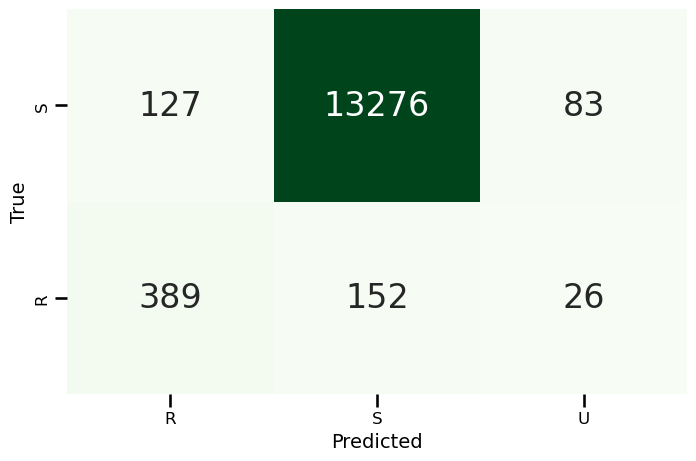

In [14]:
# Predict with catalogue
sns.set_context("talk")

cm = piezo_predict(all_cat, "./catalogues/manuscript_2/catalogue_FRS_25.csv", "BDQ")["cm"]
sens = 100 * (cm[0][0] / (cm[0][0] + cm[0][1]))
spec = 100 * (cm[1][1] / (cm[1][1] + cm[1][0]))
cov = 100 * (len(samples) - cm[0][2] - cm[1][2]) / len(samples)
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 5))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

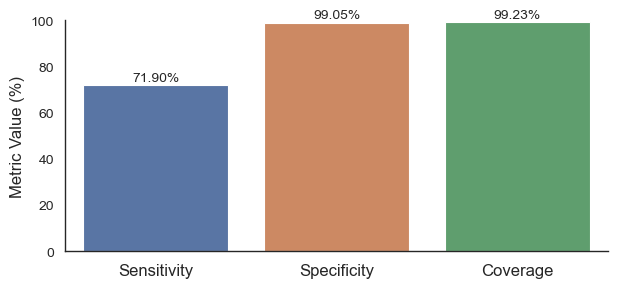

In [15]:
performance = {
    "Sensitivity": sens,
    "Specificity": spec,
    "Coverage": cov,
}
Helpers.plot_metrics(performance)

### Assume Heterogeneity and build at FRS 0.1

[[  392   151    27]
 [  138 13314   143]]
Catalogue coverage of isolates: 0.9879985880691846
Sensitivity: 0.7219152854511971
Specificity: 0.9897413024085637


Text(57.08333333333333, 0.5, 'True')

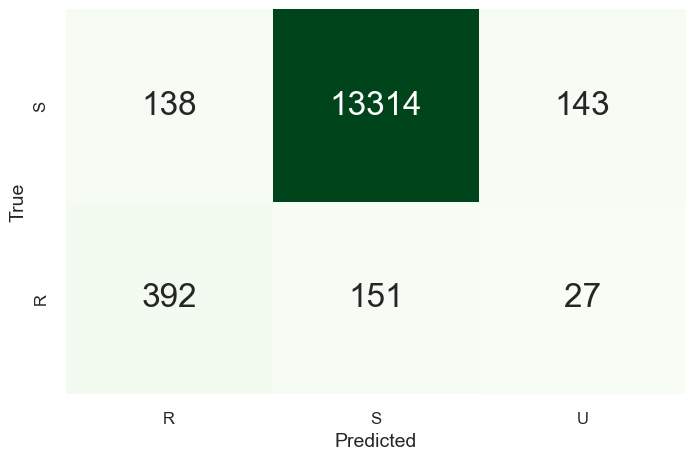

In [17]:
# Build catalogue
sns.set_context("talk")
catalogue_01 = BuildCatalogue(samples, cat_mutations, 0.10)
catalogue_01_df = (
    pd.DataFrame.from_dict(catalogue_01.return_catalogue(), orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)

# save catalogue file
catalogue_01.return_piezo(
    "NC_000962.3", "BDQ-FRS-01-2024.01", "1.1", "BDQ", piezo_wildcards
).to_csv("./catalogues/manuscript_2/catalogue_FRS_10.csv", index=False)

# Predict with catalogue
cm = piezo_predict(all, "./catalogues/manuscript_2/catalogue_FRS_10.csv", "BDQ")["cm"]
sens = 100 * (cm[0][0] / (cm[0][0] + cm[0][1]))
spec = 100 * (cm[1][1] / (cm[1][1] + cm[1][0]))
cov = 100 * (len(samples) - cm[0][2] - cm[1][2]) / len(samples)
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

plt.figure(figsize=(8, 5))
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

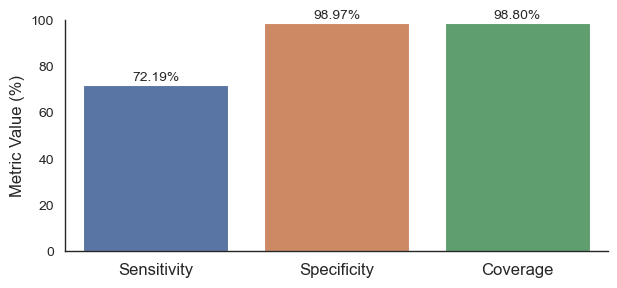

In [18]:
performance = {
    "Sensitivity": sens,
    "Specificity": spec,
    "Coverage": cov,
}
Helpers.plot_metrics(performance)

Alice used 2 reads - but used variants that they were very confident wtr to resistance, so could use a very low FRS. We are being a little more conservative (particularly with respect to pseudo-heursitc, were only one instance will be allowed in). But could go lower iwth a bigger better dataset.



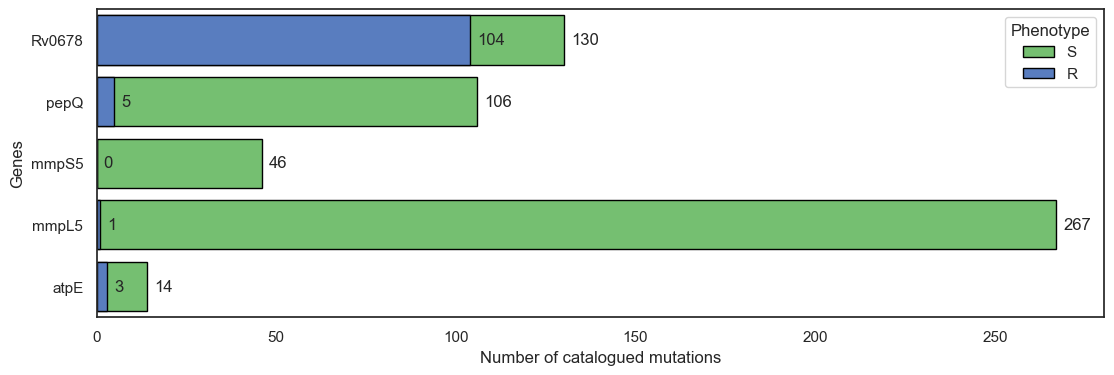

In [19]:
Helpers.plot_catalogue_counts_h(all, catalogue_01_df)


In [20]:
# Record false positives
predicted_R = all[
    all.GENE_MUT.isin(catalogue_01_df[catalogue_01_df.PHENOTYPE == "R"].MUTATION)
].UNIQUEID.unique()
fp_df = all[(all.UNIQUEID.isin(predicted_R)) & (all.PHENOTYPE == "S")]
fp_ids = fp_df.UNIQUEID.unique()

### Plot sensitivty and specificity at varying FRS thresholds

In [18]:
sns.set_context("notebook")

sens, spec, cov = [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue
    BuildCatalogue(samples, cat_mutations, i).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue
    cm = piezo_predict(all, f"./catalogues/manuscript_2/catalogue_FRS_{int(i*100)}.csv", "BDQ", Print=False)["cm"]
    sens.append(100*(cm[0][0] / (cm[0][0] + cm[0][1])))
    spec.append(100*(cm[1][1] / (cm[1][1] + cm[1][0])))
    cov.append(100*(len(samples) - cm[0][2] - cm[1][2]) / len(samples))
    FRS.append(i)



[[  392   151    27]
 [  138 13314   143]]
Catalogue coverage of isolates: 0.9879985880691846
Sensitivity: 0.7219152854511971
Specificity: 0.9897413024085637
[[  395   149    26]
 [  140 13311   144]]
Catalogue coverage of isolates: 0.9879985880691846
Sensitivity: 0.7261029411764706
Specificity: 0.9895918519069214
[[  395   154    21]
 [  137 13395    63]]
Catalogue coverage of isolates: 0.9940698905753618
Sensitivity: 0.7194899817850637
Specificity: 0.9898758498374224
[[  403   146    21]
 [  138 13390    67]]
Catalogue coverage of isolates: 0.9937875044122838
Sensitivity: 0.7340619307832422
Specificity: 0.9897989355411
[[  404   146    20]
 [  138 13388    69]]
Catalogue coverage of isolates: 0.9937169078715143
Sensitivity: 0.7345454545454545
Specificity: 0.9897974271772881
[[  405   146    19]
 [  138 13387    70]]
Catalogue coverage of isolates: 0.9937169078715143
Sensitivity: 0.73502722323049
Specificity: 0.9897966728280961
[[  391   154    25]
 [  127 13390    78]]
Catalogue cove

Sensitivity
Specificity


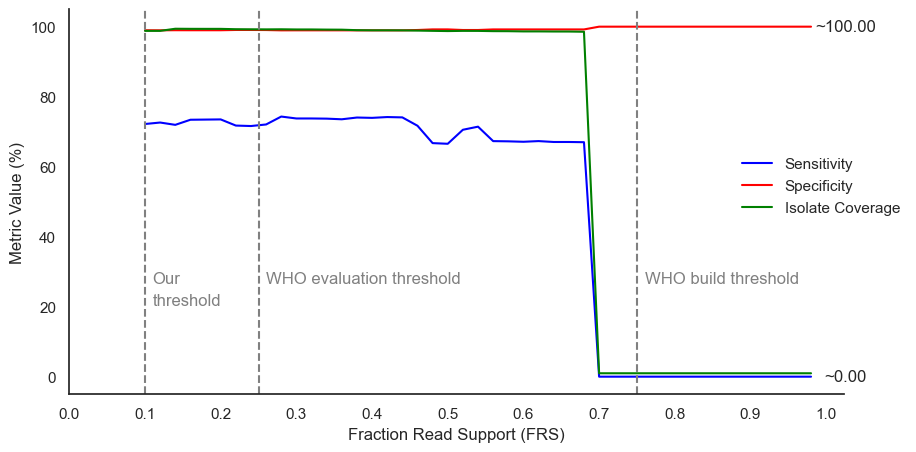

In [19]:
data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov}
)


# Create a line plot using seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x="FRS", y="Sensitivity", data=data, label="Sensitivity", color="blue")
sns.lineplot(x="FRS", y="Specificity", data=data, label="Specificity", color="red")
sns.lineplot(x="FRS", y="Coverage", data=data, label="Isolate Coverage", color="green")

yticks = [
    0,
    20,
    40,
    60,
    80,
    100,
]  # Your custom y-tick values
xticks = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1.0,
]  # Your custom y-tick values

plt.yticks(yticks)
plt.xticks(xticks)

# Add labels and legend
plt.xlabel("Fraction Read Support (FRS)")
plt.ylabel("Metric Value (%)")
plt.legend(loc="best", frameon=False, bbox_to_anchor=(0.85, 0.65))

# Add final values at the end of each line
for line in plt.gca().lines[:-1]:
    print (line.get_label())
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    final_value = y_data[-1]
    plt.annotate(
        f"~{final_value:.2f}",
        (x_data[-1], final_value),
        textcoords="offset points",
        xytext=(25, -3),
        ha="center",
    )


plt.axvline(x=0.75, color="gray", linestyle="--", label="FRS=0.75")
plt.text(0.76, 30, "WHO build threshold", color="gray", ha="left", va="top")

plt.axvline(x=0.25, color="gray", linestyle="--", label="FRS=0.25")
plt.text(0.26, 30, "WHO evaluation threshold", color="gray", ha="left", va="top")

plt.axvline(x=0.1, color="gray", linestyle="--", label="FRS=0.1")
plt.text(0.11, 30, "Our", color="gray", ha="left", va="top")
plt.text(0.11, 24, "threshold", color="gray", ha="left", va="top")

sns.despine(top=True, right=True)
plt.grid(False)

# Show the plot
plt.show()

### Cross validation at FRS=0.1, and 0.9 (supplementary figures)

FRS = 0.90

[[  76   34   16]
 [  43 2580   84]]
Catalogue coverage of isolates: 0.9647017296152488
Sensitivity: 0.6909090909090909
Specificity: 0.9836065573770492
[[  65   34   30]
 [  26 2589   89]]
Catalogue coverage of isolates: 0.9579950582421461
Sensitivity: 0.6565656565656566
Specificity: 0.990057361376673
[[  54   31   20]
 [  43 2580  105]]
Catalogue coverage of isolates: 0.955877162019061
Sensitivity: 0.6352941176470588
Specificity: 0.9836065573770492
[[  60   22   26]
 [  43 2585   97]]
Catalogue coverage of isolates: 0.9565831274267561
Sensitivity: 0.7317073170731707
Specificity: 0.9836377473363774
[[   0    0  129]
 [   0   25 2679]]
Catalogue coverage of isolates: 0.008824567596187787
Sensitivity: nan
Specificity: 1.0
isolate_cov (0.76879632897988, 0.3799987586860657)
specificity (0.9881816446934298, 0.006414073375392183)
sensitivity (nan, nan)


Text(54.08333333333333, 0.5, 'True')

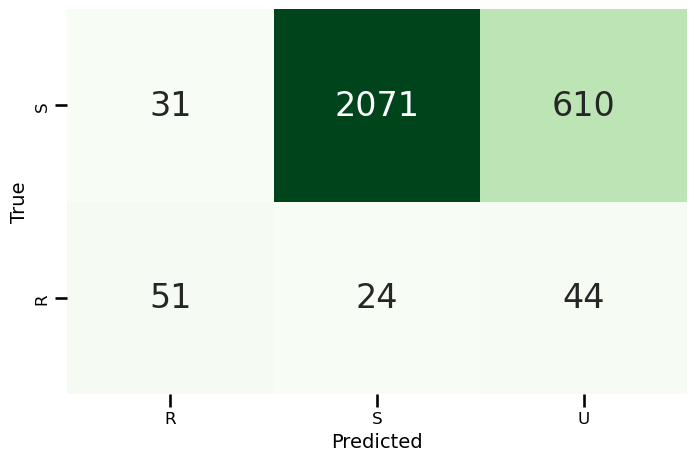

In [8]:
sns.set_context("talk")
FRS = 0.9
# Build and prediction steps are wrapped in piezo_predict_cv
df_cm, labels, sens, spec, cov = piezo_predict_cv(
    all,
    samples,
    cat_mutations,
    FRS,
    5,
    0.2,
    7,
    "NC_000962.3",
    f"BDQ-FRS-{FRS}-2024.01_cv",
    "1.1",
    "BDQ",
    piezo_wildcards,
    './catalogues/manuscript_2/cv/'
)

sns.set_context("talk")
plt.figure(figsize=(8, 5))
sns.heatmap(
    df_cm, annot=labels, cbar=False, cmap="Greens", fmt="", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

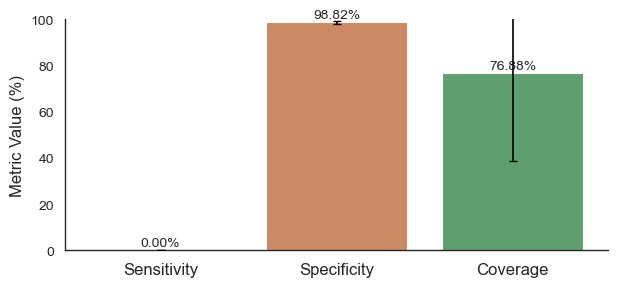

In [9]:
performance = {
    "Sensitivity": 100 * sens[0] if sens[0] == np.nan else 0,
    "Specificity": 100 * spec[0],
    "Coverage": 100 * cov[0],
}
stds = {
    "Sensitivity": 100 * sens[1] if sens[1] == np.nan else 0,
    "Specificity": 100 * spec[1],
    "Coverage": 100 * cov[1],
}

Helpers.plot_metrics_std(performance, stds)

FRS = 0.10

[[  69   41   16]
 [  31 2574  102]]
Catalogue coverage of isolates: 0.9583480409459937
Sensitivity: 0.6272727272727273
Specificity: 0.9880998080614204
[[  52   44   33]
 [  18 2584  102]]
Catalogue coverage of isolates: 0.952347334980586
Sensitivity: 0.5416666666666666
Specificity: 0.9930822444273636
[[  44   39   22]
 [  31 2594  103]]
Catalogue coverage of isolates: 0.955877162019061
Sensitivity: 0.5301204819277109
Specificity: 0.9881904761904762
[[  49   31   28]
 [  30 2605   90]]
Catalogue coverage of isolates: 0.9583480409459937
Sensitivity: 0.6125
Specificity: 0.9886148007590133
[[  72   38   19]
 [  31 2584   89]]
Catalogue coverage of isolates: 0.9618778679844687
Sensitivity: 0.6545454545454545
Specificity: 0.9881453154875717
isolate_cov (0.9573596893752206, 0.0031524339656570422)
specificity (0.9892265289851692, 0.0019366301172213443)
sensitivity (0.5932210660825119, 0.048849592348283975)


Text(57.08333333333333, 0.5, 'True')

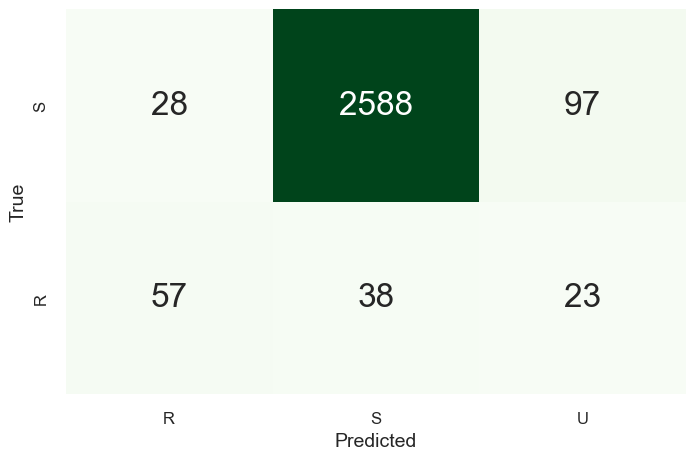

In [10]:
sns.set_context("talk")
FRS = 0.1

df_cm, labels, sens, spec, cov = piezo_predict_cv(
    all,
    samples,
    cat_mutations,
    FRS,
    5,
    0.2,
    7,
    "NC_000962.3",
    f"BDQ-FRS-{FRS}-2024.01_cv",
    "1.1",
    "BDQ",
    piezo_wildcards,
    './catalogues/manuscript_2/cv/'
)

sns.set_context("talk")
plt.figure(figsize=(8, 5))
sns.heatmap(
    df_cm, annot=labels, cbar=False, cmap="Greens", fmt="", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

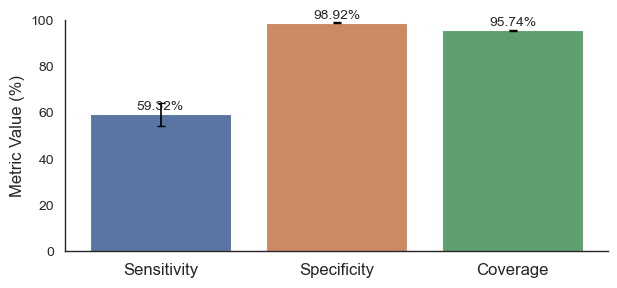

In [11]:
performance = {
    "Sensitivity": 100*sens[0],
    "Specificity": 100 * spec[0],
    "Coverage": 100 * cov[0],
}
stds = {
    "Sensitivity": 100 * sens[1],
    "Specificity": 100 * spec[1],
    "Coverage": 100 * cov[1],
}

Helpers.plot_metrics_std(performance, stds)

Our method is performing well using FRS thresholds of 0.65 and below, however the vast majority of mmpL5 variants are catalogued as susceptible (249/250), which would suggest mmpL5 does not contirbute to resistance against BDQ. Therefore should be able to remove it with little effect on performance

## Remove mmpL5-mmpS5, rebuild  catalogue and predict

I see several ways to do this. Build catalogue without mmpL5. The validate on a dataset with mmpL5 removed (which will remove a lot of samples). Or validate on the same samples as before, but make mmpL5 mutations wildtype or synonymous

In [21]:
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]

In [22]:
gene_mut_no_mmpL5 = []
for i in all.index:
    if all['GENE'][i]=='mmpL5': 
        #make all mmpL5 mutations synonymous so piezo automatically call them S
        gene_mut_no_mmpL5.append('mmpL5@A1A')
    else:
        gene_mut_no_mmpL5.append(all['GENE_MUT'][i])
all_WT_mmpL5 = all.copy()
all_WT_mmpL5['GENE_MUT'] = gene_mut_no_mmpL5
all_WT_mmpL5

#Say something about 'made model treat every mmpL5 mutation as susceptible' (don't mention making synonymous)


,UNIQUEID,DRUG,PHENOTYPE,METHOD_MIC,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,...,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUT,IS_SYNONYMOUS
0,site.01.subj.DR0682.lab.DR0682.iso.1,BDQ,S,0.03,mmpL5,D767N,gac,aac,NaN,NaN,...,NaN,NaN,767.0,N,1.0,False,NaN,1.0,mmpL5@A1A,False
1,site.01.subj.DR0682.lab.DR0682.iso.1,BDQ,S,0.03,mmpL5,T794I,acc,atc,NaN,NaN,...,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5@A1A,False
2,site.01.subj.DR0682.lab.DR0682.iso.1,BDQ,S,0.03,mmpL5,I948V,att,gtt,NaN,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False
3,site.01.subj.DR0674.lab.DR0674.iso.1,BDQ,S,0.03,mmpL5,I948V,att,gtt,NaN,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False
4,site.01.subj.DR0134.lab.DR0134.iso.1,BDQ,S,0.06,mmpL5,T794I,acc,atc,NaN,NaN,...,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5@A1A,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29735,site.14.subj.1590.lab.1590.iso.1,BDQ,S,0.12,pepQ,G197R,ggg,agg,NaN,NaN,...,NaN,NaN,197.0,R,1.0,False,NaN,1.0,pepQ@G197R,False
29736,site.14.subj.4200.lab.4200.iso.1,BDQ,S,0.06,mmpL5,T794I,acc,atc,NaN,NaN,...,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5@A1A,False
29737,site.14.subj.4200.lab.4200.iso.1,BDQ,S,0.06,mmpL5,I948V,att,gtt,NaN,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False
29738,site.14.subj.4395.lab.4395.iso.1,BDQ,S,0.015,mmpL5,I948V,att,gtt,NaN,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False


[[  419   127    24]
 [  147 13266   182]]
Catalogue coverage of isolates: 0.9854571126014825
Sensitivity: 0.7673992673992674
Specificity: 0.9890404831133974


Text(57.08333333333333, 0.5, 'True')

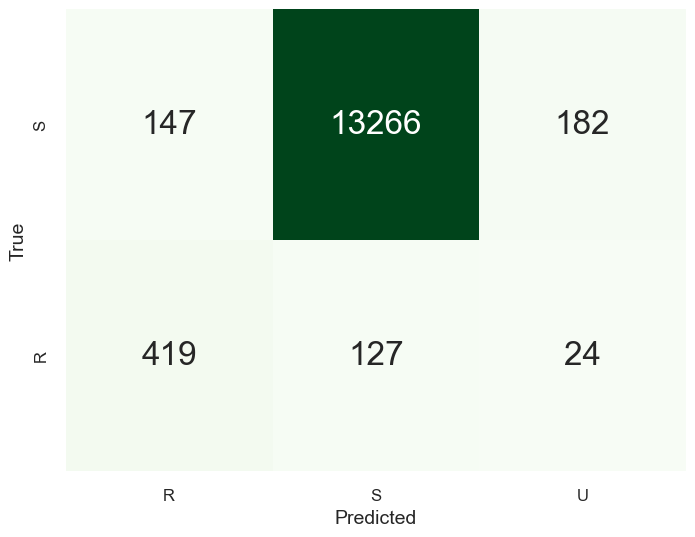

In [23]:
# Build catalogue with mmpL5's predicted as S/treated as not relevant
catalogue_01_no_mmpL5 = BuildCatalogue(samples, mutations_no_mmpL5, 0.1)
catalogue_01_no_mmpL5_df = (
    pd.DataFrame.from_dict(catalogue_01_no_mmpL5.return_catalogue(), orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)
# save catalogue file
catalogue_01_no_mmpL5.return_piezo(
    "NC_000962.3", "BDQ-FRS-10-2024.01-rm-mmpL5", "1.1", "BDQ", piezo_wildcards
).to_csv("./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10_rm_mmpL5.csv", index=False)

# predict with catalogue
cm = piezo_predict(
    all_WT_mmpL5, "./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10_rm_mmpL5.csv", "BDQ"
)["cm"]
sens = 100 * (cm[0][0] / (cm[0][0] + cm[0][1]))
spec = 100 * (cm[1][1] / (cm[1][1] + cm[1][0]))
cov = 100 * (len(samples) - cm[0][2] - cm[1][2]) / len(samples)
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

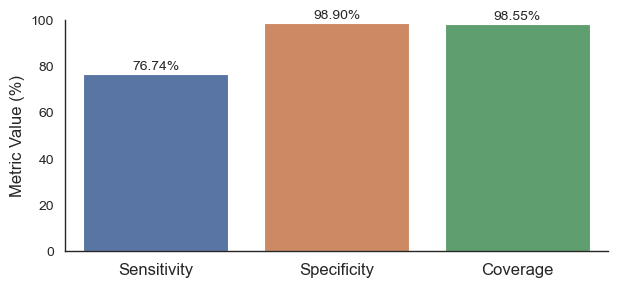

In [24]:
performance = {
    "Sensitivity": sens,
    "Specificity": spec,
    "Coverage": cov,
}
Helpers.plot_metrics(performance)

In [25]:
# Record false positives
predicted_R_no_mmpL5 = all_WT_mmpL5[
    all_WT_mmpL5.GENE_MUT.isin(
        catalogue_01_no_mmpL5_df[catalogue_01_no_mmpL5_df.PHENOTYPE == "R"].MUTATION
    )
].UNIQUEID.unique()
fp_df_no_mmpL5 = all_WT_mmpL5[
    (all_WT_mmpL5.UNIQUEID.isin(predicted_R_no_mmpL5)) & (all_WT_mmpL5.PHENOTYPE == "S")
]
fp_ids_no_mmpL5 = fp_df_no_mmpL5.UNIQUEID.unique()


#How many of the false positives are shared with those when mmpL5 was included?
overlap = [fp for fp in fp_ids if fp in fp_ids_no_mmpL5]
len(overlap)

126

Removing mmpL5 achieves a significant increase in sensitivity, but at the cost of a drop in specificity. However, this drop is not surprising given how many susceptible samples we have lost, and 130/146 of the false positives are the same as those when mmpL5 was included.

### Is there any correlation between FRS and MIC?

In [26]:
all["MIC_FLOAT"] = Helpers.mic_to_float(all["METHOD_MIC"].tolist())


R_muts = catalogue_01_df[catalogue_01_df.PHENOTYPE == "R"].MUTATION.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.GENE_MUT.isin(R_muts))]) == 1:
        solo_Rs.append(i)

df = pd.DataFrame.from_dict(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

print(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]

df["MIC"] = [str(i) for i in df.MIC]

{'GENE_MUT': ['Rv0678@383_del_c', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@465_ins_c', 'atpE@E61D', 'Rv0678@132_ins_gt', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@L32S', 'Rv0678@141_ins_c', 'Rv0678@Q115!', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@138_ins_g', 'pepQ@298_ins_c', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'atpE@A63P', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@Y92!', 'Rv0678@471_del_cagc', 'Rv0678@141_ins_c', 'Rv0678@L40F', 'Rv0678@S63R', 'Rv0678@I67S', 'Rv0678@L32S', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@132_ins_gt', 'Rv0678@132_ins_gt', 'Rv0678@376_del_ggcgac', 'Rv0678@141_ins_c', 'pepQ@151_ins_c', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@140_ins_tc', 'Rv0678@199_ins_tc', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@132_ins_gt', 'Rv0678@141_ins_c', 'Rv0678@148_ins_g', 'Rv0

In [27]:
df[df.GENE_MUT=='Rv0678@141_ins_c'].MIC.value_counts()

4.0     38
2.0     26
8.0     23
0.25    18
0.06    13
0.12    10
0.5      8
1.0      5
Name: MIC, dtype: int64

In [28]:
df

,GENE_MUT,FRS,MIC,binned_FRS,binned_MIC
0,Rv0678@383_del_c,1.000,0.015,1.0,0.015
1,Rv0678@141_ins_c,0.596,0.06,0.6,0.06
2,Rv0678@138_ins_g,0.462,0.5,0.5,0.5
3,Rv0678@141_ins_c,1.000,0.06,1.0,0.06
4,Rv0678@465_ins_c,1.000,0.12,1.0,0.12
...,...,...,...,...,...
424,Rv0678@L40F,1.000,0.5,1.0,0.5
425,mmpL5@L709I,1.000,0.5,1.0,0.5
426,Rv0678@325_ins_g,1.000,1.0,1.0,1.0
427,Rv0678@138_ins_g,1.000,0.25,1.0,0.25


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_3730/517711808.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_3730/517711808.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(


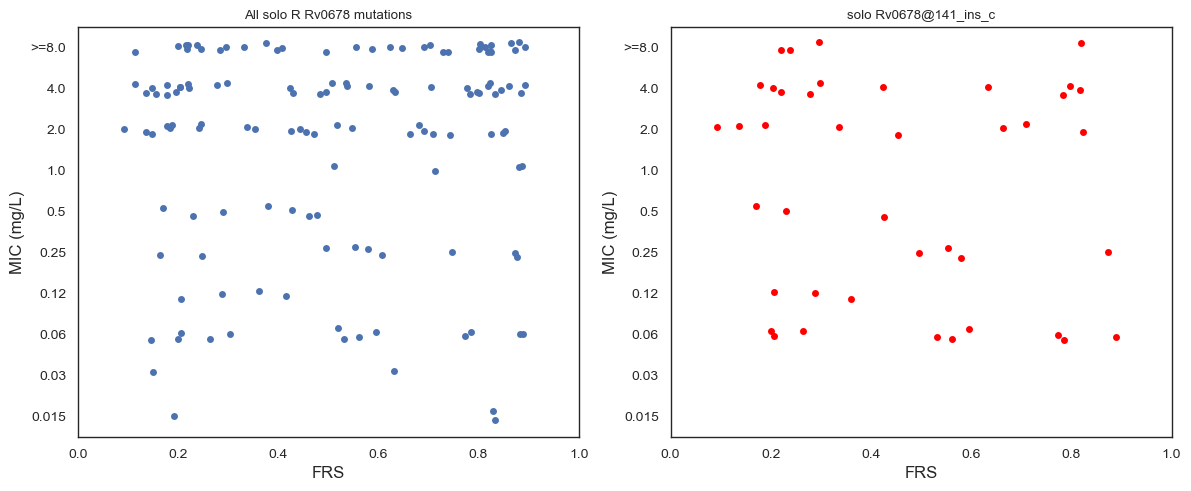

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.set_context("paper")

# axes[0].set_ylim(0, 3.5)
y_axis_order = [
    "0.015",
    "0.03",
    "0.06",
    "0.12",
    "0.25",
    "0.5",
    "1.0",
    "2.0",
    "4.0",
    "8.0",
]

sns.stripplot(
    x="FRS", y="MIC", data=df[df.FRS < 0.9], ax=axes[0], jitter=0.15, order=y_axis_order
)
axes[0].set_title("All solo R Rv0678 mutations")
axes[0].invert_yaxis()
axes[0].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)
axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("MIC (mg/L)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)


axes[0].set_xlim(0, 1)

sns.stripplot(
    x="FRS",
    y="MIC",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    jitter=0.15,
    color="red",
    order=y_axis_order,
)
axes[1].set_title("solo Rv0678@141_ins_c")
axes[1].invert_yaxis()
axes[1].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)

axes[1].set_xlim(0, 1)
# axes[1].set_ylim(0, 3.5)
axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("MIC (mg/L)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

There is no correlation between FRS and MIC for Rv0678 resistant variants generally, as well as for the most variable (wrt FRS) mutations in Rv0678. This would suggest there is no effective fitness cost resulting from Rv0678 resistant mutations, as minor resistant populations can rapidly outcompete major WT populations. It would be interesting to analyse growth data from the plates, however this data is not available.

## Is there any correlation between FRS and growth?

In [30]:
growth_dil = growth[(growth.DILUTION.isin([1, 2, 3])) & (growth.READINGDAY == 14)]
# subset growth data to dilutions of 1, 2, or 3 fold so there is drug present, and only look at growth at 14 days post incubation
growth_dil = growth_dil[["UNIQUEID", "GROWTH"]].groupby("UNIQUEID").mean()
# average growth across dilutions
growth_dil

,GROWTH
UNIQUEID,
site.01.subj.DR0013.lab.DR0013.iso.1,13.239288
site.01.subj.DR0018.lab.DR0018.iso.1,35.075825
site.01.subj.DR0025.lab.DR0025.iso.1,14.489963
site.01.subj.DR0030.lab.DR0030.iso.1,41.714438
site.01.subj.DR0031.lab.DR0031.iso.1,4.745861
...,...
site.20.subj.SCH8604398.lab.YA00134621.iso.1,20.066556
site.20.subj.SCH8604399.lab.YA00134971.iso.1,19.883464
site.20.subj.SCH8608291.lab.YA00135762.iso.1,11.091854


In [31]:
df = pd.merge(growth_dil, cat_mutations[cat_mutations.GENE=='Rv0678'], how='inner', on='UNIQUEID')
#filter for samples with only a single resistant mutation (and however many S)
df = df[df.UNIQUEID.isin(solo_Rs)]

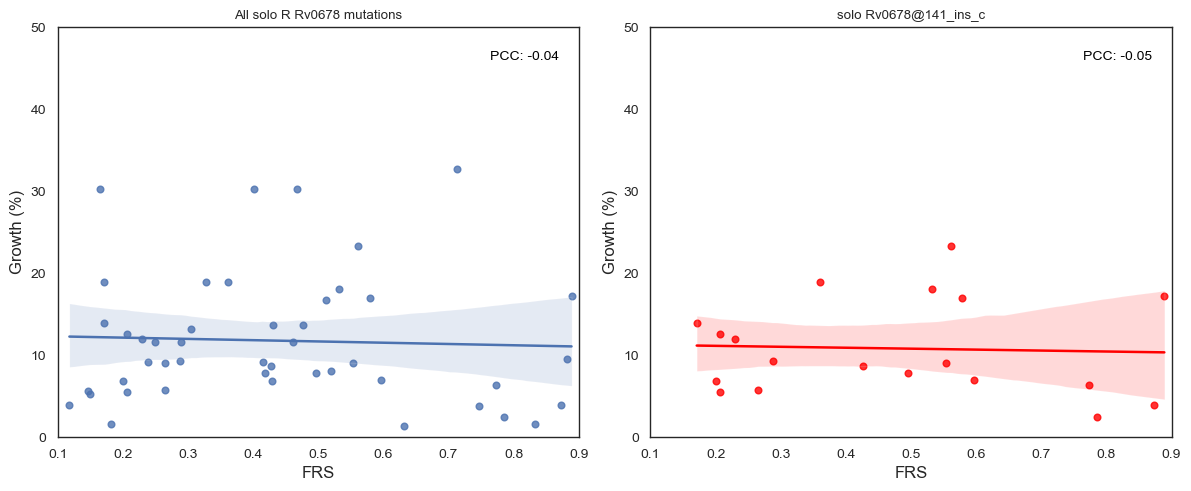

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.regplot(x="FRS", y="GROWTH", data=df[df.FRS < 0.9], ax=axes[0], ci=95)
axes[0].set_title("All solo R Rv0678 mutations")
axes[0].set_xlim(0.1, 0.9)
axes[0].set_ylim(0, 50)

axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("Growth (%)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)

# Calculate Pearson correlation coefficient
pcc_value = df[df.FRS < 0.9][["FRS", "GROWTH"]].corr().iloc[0, 1]

# Annotate the first subplot with the PCC value
axes[0].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


sns.regplot(
    x="FRS",
    y="GROWTH",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    color="red",
    ci=95,
)
axes[1].set_title("solo Rv0678@141_ins_c")
axes[1].set_xlim(0.1, 0.9)  # Set x-axis range
axes[1].set_ylim(0, 50)

axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("Growth (%)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Calculate Pearson correlation coefficient
pcc_value = (
    df[(df.FRS < 0.9) & (df.GENE_MUT == "Rv0678@141_ins_c")][["FRS", "GROWTH"]]
    .corr()
    .iloc[0, 1]
)

# Annotate the first subplot with the PCC value
axes[1].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


# Adjust layout
plt.tight_layout()

# Show the plot

## Why does exlcuding minor alleles stall the heuristic method?

If we compare mmpL5 and Rv0678 variants with and without minor alleles we can see a shift in distribution of lone-ocurring variants, which are used to call the phenotype. 

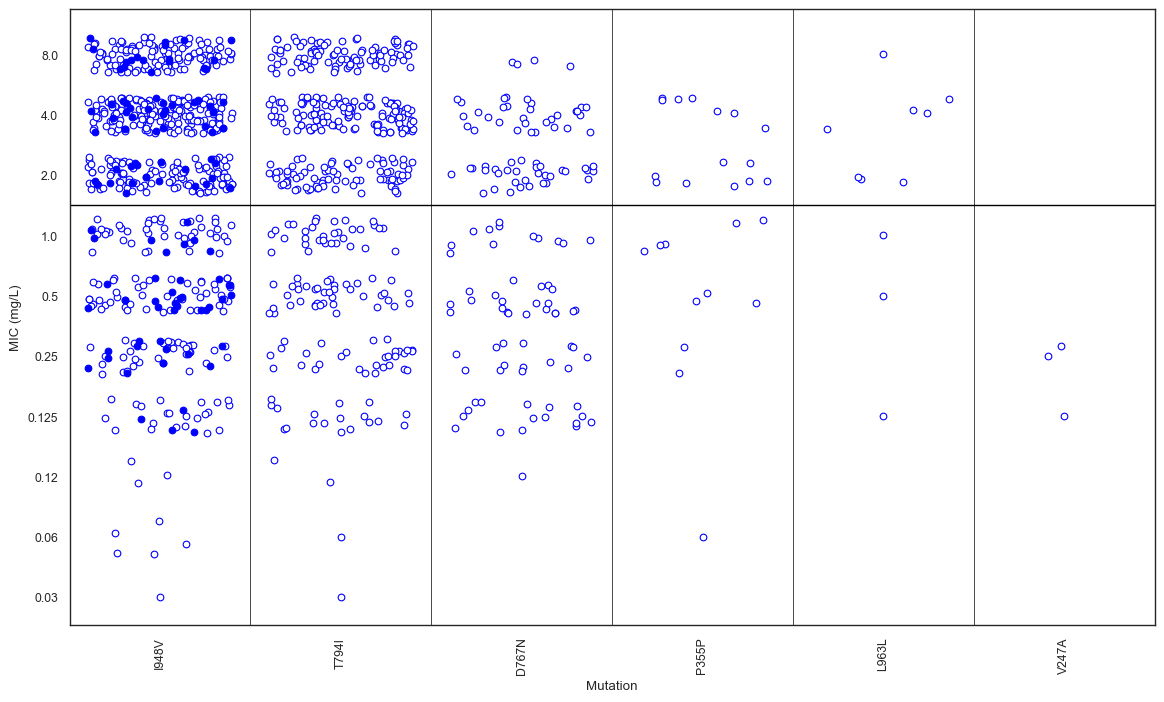

In [33]:
sha_phenotypes = pd.read_pickle(
    "./data/shaheed/DST_MEASUREMENTS.pkl.gz"
).reset_index()
sha_phenotypes = sha_phenotypes[sha_phenotypes.DRUG == "BDQ"][
    ["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC"]
]


all["MIC_FLOAT"] = Helpers.mic_to_float(all["METHOD_MIC"].tolist())
Helpers.mutation_mic_plot(
    all[all.FRS > 0.9], sha_phenotypes.UNIQUEID.unique(), "mmpL5", 1.0, (14, 8)
)

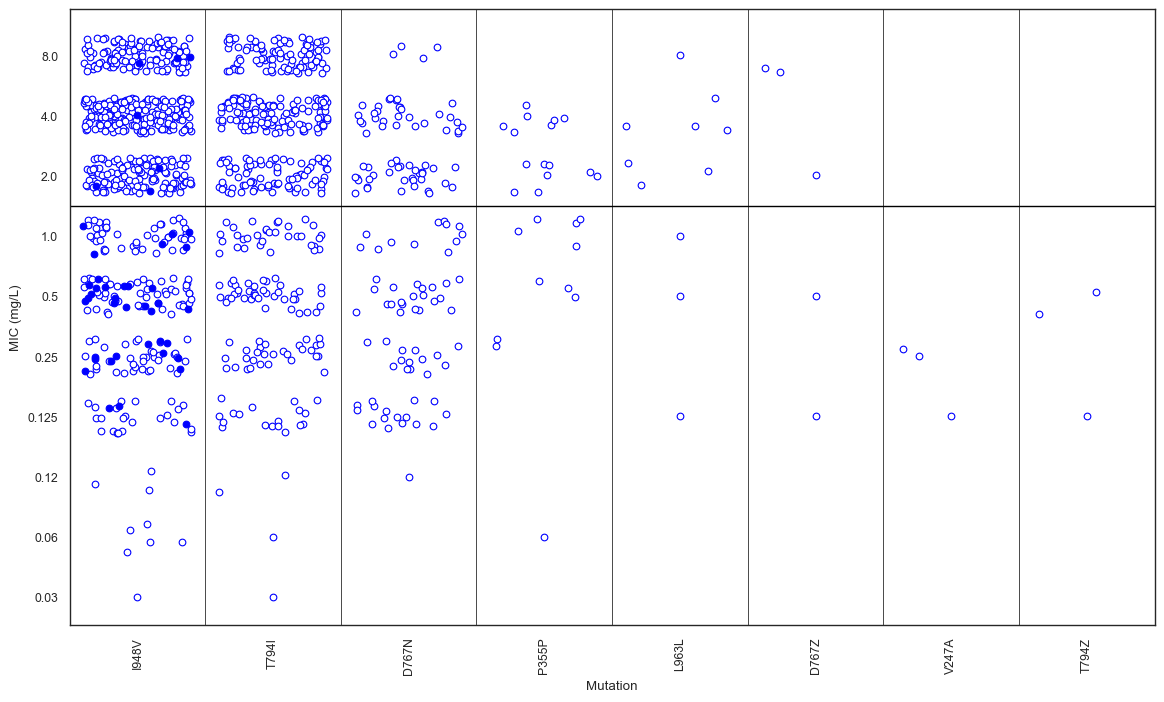

In [34]:
Helpers.mutation_mic_plot(all, sha_phenotypes.UNIQUEID.unique(), "mmpL5", 1.0, (14, 8))

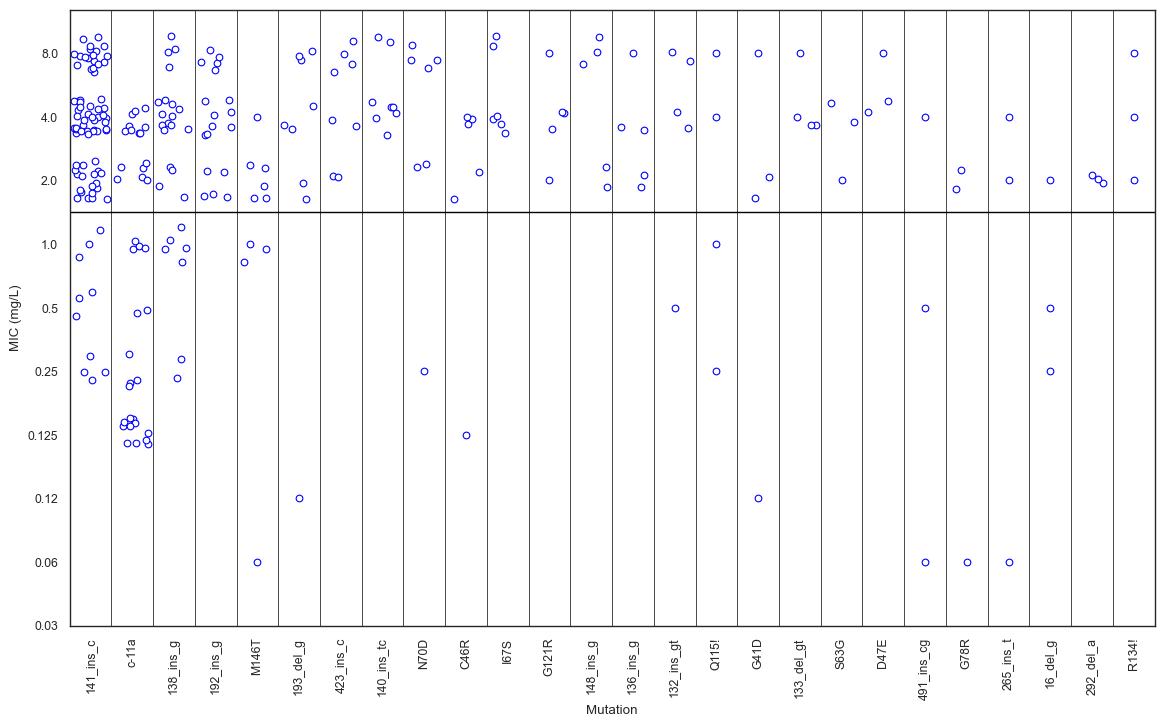

In [35]:
Helpers.mutation_mic_plot(all[all.FRS>0.9], sha_phenotypes.UNIQUEID.unique(), "Rv0678", 1.0, (14, 8))

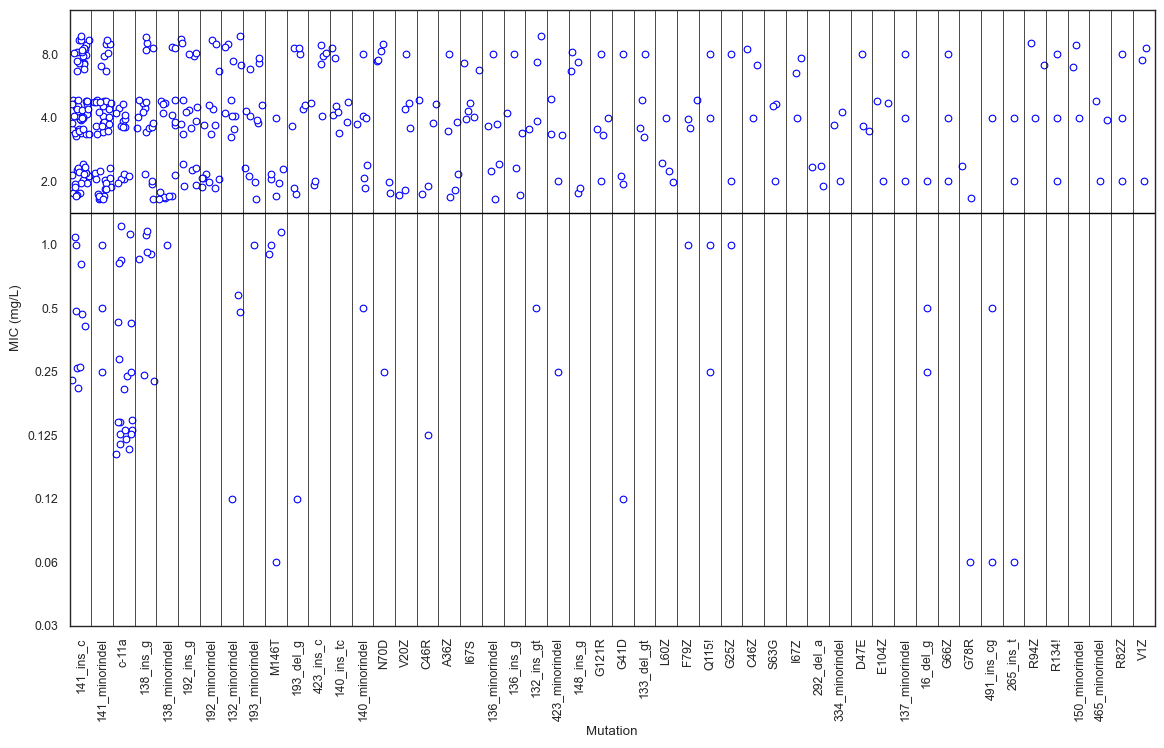

In [36]:
Helpers.mutation_mic_plot(all, sha_phenotypes.UNIQUEID.unique(), "Rv0678", 1.0, (14, 8))